### 1. Problem Statement

   - Build a product recommendation engine based on historical purchase behavior from the Online Retail dataset. The goal is to recommend relevant products to users, enhancing customer experience and potentially boosting sales.

### 2. Dataset Understanding

  -  Source: UCI Machine Learning Repository (Online Retail Dataset)

  - Key Columns:

        InvoiceNo, StockCode, Description, Quantity, InvoiceDate, UnitPrice, CustomerID, Country

  - Objective: Use CustomerID and their purchase history to generate item recommendations.

In [ ]:
pip install ucimlrepo

from ucimlrepo import fetch_ucirepo 
  
# fetch dataset 
online_retail = fetch_ucirepo(id=352) 
  
# data (as pandas dataframes) 
X = online_retail.data.features 
id = online_retail.data.ids 
data= pd.concat([id,X],axis=1)
  
# variable information 
print(online_retail.variables) 
print(data.head())

### 3. Assumptions

  -  Each unique CustomerID represents a single user.

  -  We'll treat each invoice as a transaction (basket).

  -  Products returned (negative quantity) will be removed.

  -  Recommendations will be based on past purchase similarity or co-occurrence.

### 4. Data Cleaning Strategy

   - Remove missing CustomerID values.

   - Drop rows where Quantity <= 0 or UnitPrice <= 0.

   - Filter for one country (e.g., United Kingdom) to simplify the model (optional).

   - Convert InvoiceDate to datetime and extract useful features if needed.

### 5. Exploratory Data Analysis (EDA)

   - Top-selling products

   - Frequency of purchases per customer

   - Number of items per transaction

   - Most active customers

   - Basket size distribution

### 6. Approach

You can choose one or both models:
- A. Collaborative Filtering (User-based / Item-based)

    Using surprise or cosine similarity with a user-item matrix

    Recommend products similar to those a user has purchased

- B. Association Rule Mining

    Use the mlxtend library (Apriori algorithm)

    Generate rules like: "Customers who bought X also bought Y"

## 1. Import Libraries & Load Data

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from ucimlrepo import fetch_ucirepo
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import MinMaxScaler


In [18]:
# Fetch dataset using ucimlrepo

from ucimlrepo import fetch_ucirepo 

# fetch dataset 
online_retail = fetch_ucirepo(id=352) 

# data (as pandas dataframes) 
X = online_retail.data.features 
id = online_retail.data.ids 
data= pd.concat([id,X],axis=1)

# variable information 
print(online_retail.variables) 
print(data.head())


          name     role         type demographic  \
0    InvoiceNo       ID  Categorical        None   
1    StockCode       ID  Categorical        None   
2  Description  Feature  Categorical        None   
3     Quantity  Feature      Integer        None   
4  InvoiceDate  Feature         Date        None   
5    UnitPrice  Feature   Continuous        None   
6   CustomerID  Feature  Categorical        None   
7      Country  Feature  Categorical        None   

                                         description     units missing_values  
0  a 6-digit integral number uniquely assigned to...      None             no  
1  a 5-digit integral number uniquely assigned to...      None             no  
2                                       product name      None             no  
3  the quantities of each product (item) per tran...      None             no  
4  the day and time when each transaction was gen...      None             no  
5                             product price per uni

# 2. Data Cleaning

In [5]:
# Drop missing CustomerIDs
data.dropna(subset=['CustomerID'], inplace=True)

# Remove cancelled orders and returns
data = data[data['Quantity'] > 0]
data = data[data['UnitPrice'] > 0]

# Convert data types
data['CustomerID'] = data['CustomerID'].astype(int)
data['InvoiceDate'] = pd.to_datetime(data['InvoiceDate'])

# Optional: Filter by country (UK)
data = data[data['Country'] == 'United Kingdom']

# 3. Exploratory Data Analysis (EDA)

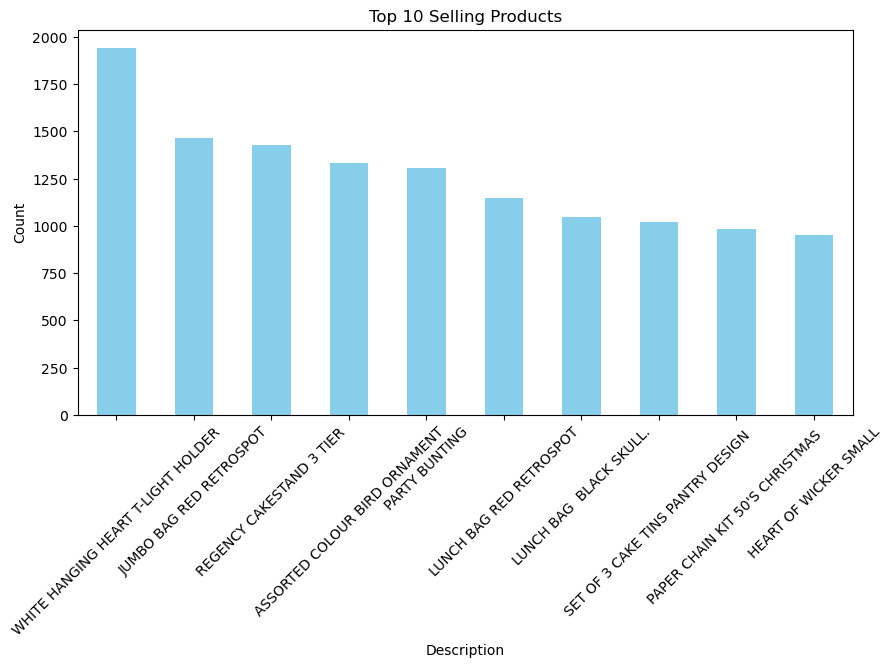

In [6]:
# Top 10 selling products
top_products = data['Description'].value_counts().head(10)
plt.figure(figsize=(10,5))
top_products.plot(kind='bar', color='skyblue')
plt.title('Top 10 Selling Products')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

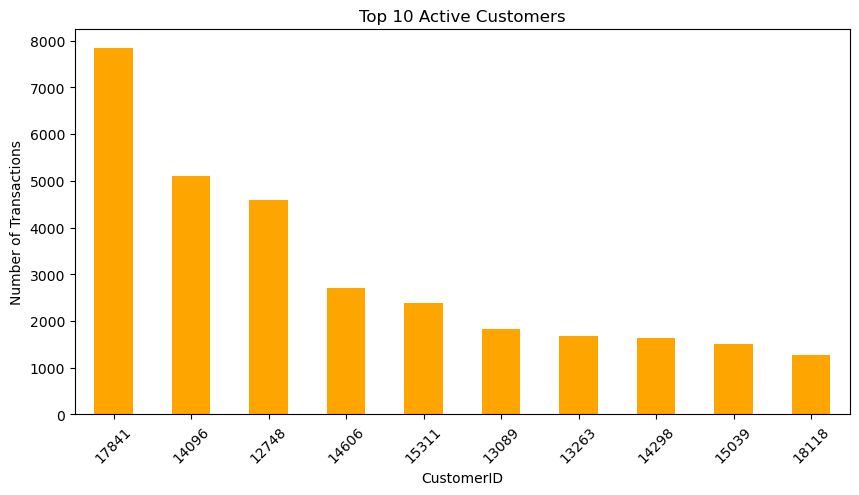

In [7]:
# Most active customers
top_customers = data['CustomerID'].value_counts().head(10)
plt.figure(figsize=(10,5))
top_customers.plot(kind='bar', color='orange')
plt.title('Top 10 Active Customers')
plt.ylabel('Number of Transactions')
plt.xticks(rotation=45)
plt.show()

c:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


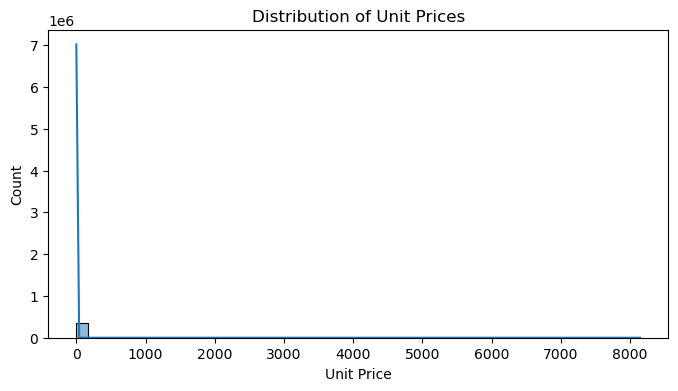

In [8]:
# Distribution of Unit Prices
plt.figure(figsize=(8,4))
sns.histplot(data['UnitPrice'], bins=50, kde=True)
plt.title('Distribution of Unit Prices')
plt.xlabel('Unit Price')
plt.show()

c:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


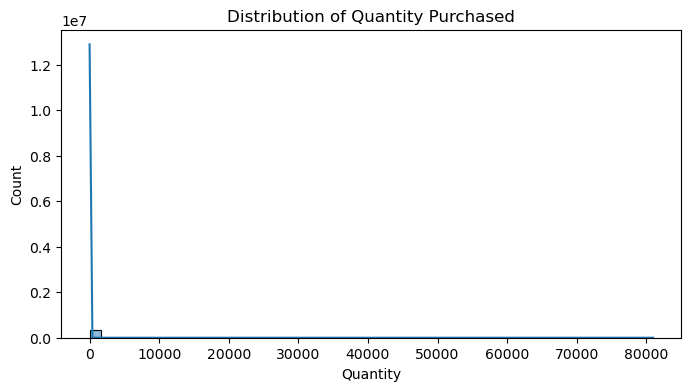

In [9]:
# Quantity Distribution
plt.figure(figsize=(8,4))
sns.histplot(data['Quantity'], bins=50, kde=True)
plt.title('Distribution of Quantity Purchased')
plt.xlabel('Quantity')
plt.show()

c:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


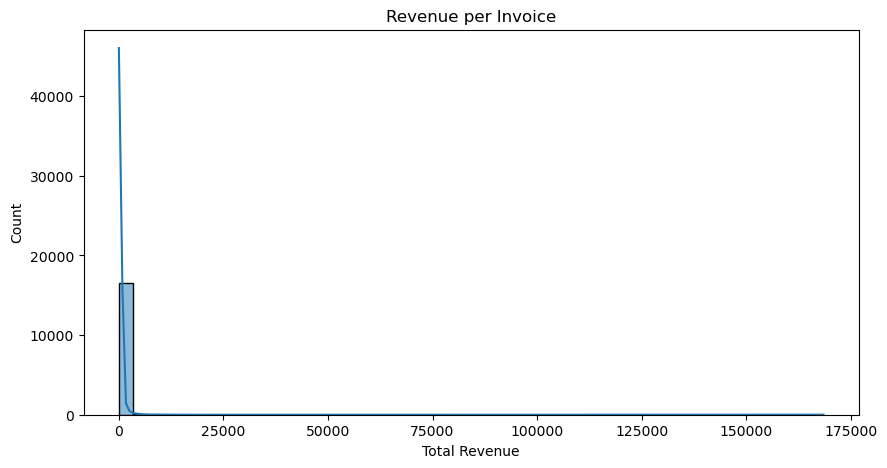

In [10]:
# Revenue per transaction
data['TotalPrice'] = data['Quantity'] * data['UnitPrice']
revenue_per_invoice = data.groupby('InvoiceNo')['TotalPrice'].sum()
plt.figure(figsize=(10,5))
sns.histplot(revenue_per_invoice, bins=50, kde=True)
plt.title('Revenue per Invoice')
plt.xlabel('Total Revenue')
plt.show()

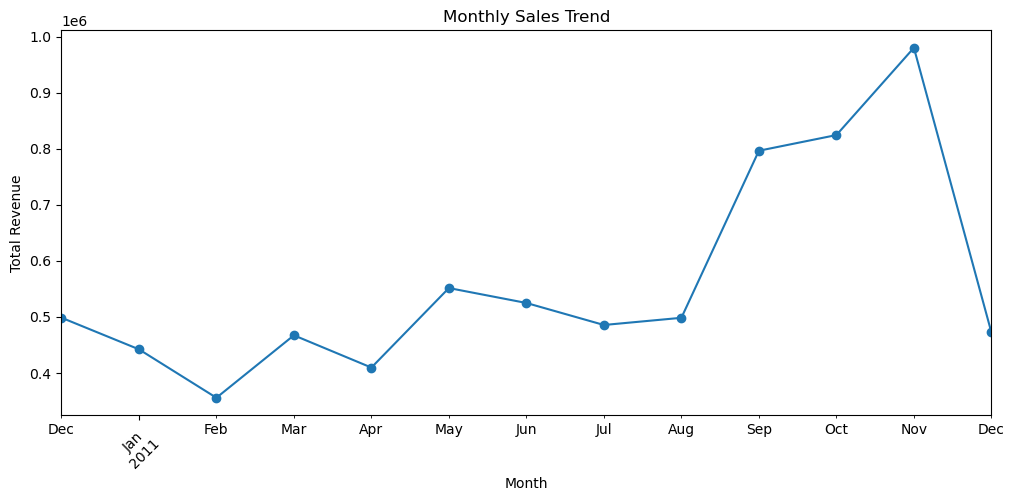

In [11]:
# Monthly sales trend
data['Month'] = data['InvoiceDate'].dt.to_period('M')
monthly_sales = data.groupby('Month')['TotalPrice'].sum()
plt.figure(figsize=(12,5))
monthly_sales.plot(marker='o')
plt.title('Monthly Sales Trend')
plt.ylabel('Total Revenue')
plt.xticks(rotation=45)
plt.show()

# 4. Feature Engineering

In [12]:
# Create a customer-product matrix
basket = data.pivot_table(index='CustomerID', columns='Description', values='Quantity', aggfunc='sum').fillna(0)

# Normalize the basket
scaler = MinMaxScaler()
basket_scaled = pd.DataFrame(scaler.fit_transform(basket), columns=basket.columns, index=basket.index)

# 5. Build Item-Based Collaborative Filtering

In [13]:
# Compute cosine similarity between products
item_similarity = cosine_similarity(basket_scaled.T)
item_similarity_df = pd.DataFrame(item_similarity, index=basket.columns, columns=basket.columns)


# 6. Recommend Similar Items

In [14]:
def recommend_similar_items(product_name, top_n=5):
    if product_name not in item_similarity_df.columns:
        return f"'{product_name}' not found in product list."
    similar_items = item_similarity_df[product_name].sort_values(ascending=False)[1:top_n+1]
    return similar_items

# Example usage
recommend_similar_items("WHITE HANGING HEART T-LIGHT HOLDER")

Description
GIN + TONIC DIET METAL SIGN         0.755288
RED HANGING HEART T-LIGHT HOLDER    0.657548
WASHROOM METAL SIGN                 0.648820
LAUNDRY 15C METAL SIGN              0.648707
GREEN VINTAGE SPOT BEAKER           0.636232
Name: WHITE HANGING HEART T-LIGHT HOLDER, dtype: float64

# 7. Business Insights
 - You can recommend similar products to what a customer has purchased.
 - Identify common product bundles.
 - Suggest cross-sell opportunities during checkout.

# 8. (Bonus) Save Model for API Deployment

In [15]:
# Save item similarity matrix for use in a Flask/FastAPI app
item_similarity_df.to_csv("item_similarity_matrix.csv")